In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive
%cd MyDrive
%cd shiz

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/shiz


In [ ]:
sorted_idx = logreg.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], logreg.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.2 MB/s eta 0:00:00


In [5]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold

In [6]:
scoring = ['recall', 'accuracy', 'f1', 'roc_auc']

In [7]:
df = pd.read_excel('df_standard_cleaned_21feb.xlsx') 
df1d = pd.read_excel('df_standard_only1dfeatures.xlsx')

df = df.set_index('ID')
df1d = df1d.set_index('ID')
df.head(1)

,sex,tds,chroma_cens_avg,chroma_cens_std,chroma_cqt_avg,chroma_cqt_std,chroma_stft_avg,chroma_stft_std,melspectrogram_avg,melspectrogram_std,...,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std,tds_binary
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,0,0.685706,0.428088,0.425039,0.296394,0.339246,0.434412,0.327867,0.348849,...,0.31499,0.397736,0.254215,0.747885,0.719312,0.691479,0.329593,0.197304,0.281692,0


**Non-binary**

All features

In [20]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [21]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10),
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8912655971479501
test score: 0.8823529411764706
best_params: OrderedDict([('max_depth', 67), ('min_samples_leaf', 0.3889111111111111), ('min_samples_split', 0.8889), ('n_estimators', 426)])


In [22]:
rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.88        68
   macro avg       0.29      0.33      0.31        68
weighted avg       0.78      0.88      0.83        68



In [11]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8882352941176471 ± 0.19939354419621522
recall 0.7666666666666666 ± 0.2905932629027116


Text(0.5, 0, 'Random Forest Feature Importance')

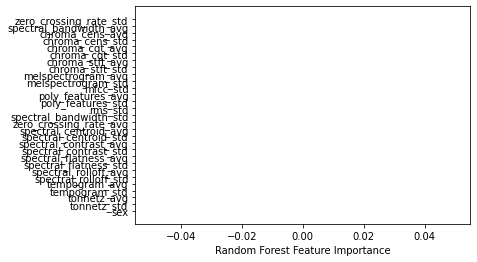

In [27]:
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


In [25]:
rfc.feature_importances_[sorted_idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Only 1D features

In [12]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [13]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10),
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10),
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8912655971479501
test score: 0.8823529411764706
best_params: OrderedDict([('max_depth', 40), ('min_samples_leaf', 0.05564444444444445), ('min_samples_split', 0.33340000000000003), ('n_estimators', 538)])


In [14]:
rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        60
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         2

    accuracy                           0.88        68
   macro avg       0.29      0.33      0.31        68
weighted avg       0.78      0.88      0.83        68



In [15]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8761029411764707 ± 0.193998194641655
recall 0.6606004901960784 ± 0.28274935816840735


Text(0.5, 0, 'Random Forest Feature Importance')

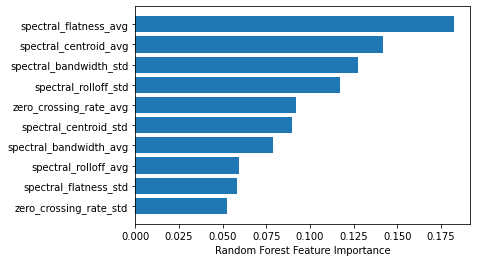

In [16]:
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

**Binary**

All features

In [40]:
X = df.drop(['tds', 'tds_binary'], axis=1)
y = df.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

In [41]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10), #add integers greater than 1
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10), #add integers greater than 1
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8814814814814814
test score: 0.9411764705882353
best_params: OrderedDict([('max_depth', 29), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.33340000000000003), ('n_estimators', 589)])


In [42]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       0.00      0.00      0.00         2

    accuracy                           0.94        34
   macro avg       0.47      0.50      0.48        34
weighted avg       0.89      0.94      0.91        34



In [43]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8702205882352942 ± 0.192824135613482
recall 0.7378676470588236 ± 0.25658393508546995


Text(0.5, 0, 'Random Forest Feature Importance')

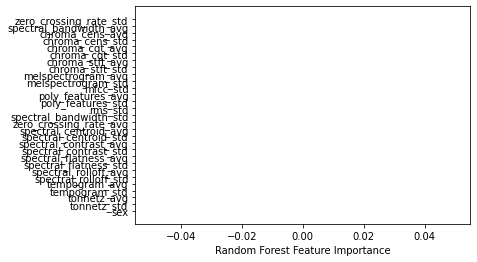

In [33]:
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Only 1D features

In [44]:
X = df1d.drop(['tds', 'tds_binary'], axis=1)
y = df1d.tds_binary # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [45]:
warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100),
        'min_samples_split': np.linspace(0.0001, 1, 10), #add integers greater than 1
        'min_samples_leaf': np.linspace(0.0001, 0.5, 10), #add integers greater than 1
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.9010695187165775
test score: 0.8970588235294118
best_params: OrderedDict([('max_depth', 100), ('min_samples_leaf', 0.0001), ('min_samples_split', 0.0001), ('n_estimators', 1000)])


In [46]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = opt.best_params_['n_estimators'], 
                             max_depth = opt.best_params_['max_depth'],
                             min_samples_split = opt.best_params_['min_samples_split'],
                             min_samples_leaf = opt.best_params_['min_samples_leaf'])
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94        60
           1       0.60      0.38      0.46         8

    accuracy                           0.90        68
   macro avg       0.76      0.67      0.70        68
weighted avg       0.88      0.90      0.89        68



In [47]:
kf = KFold(n_splits=10)

crossval_accuracy = cross_val_score(rfc, X, y, scoring='accuracy', cv = kf)
mean_score = crossval_accuracy.mean()
std_score = crossval_accuracy.std()
print('accuracy', mean_score, '±', std_score)

crossval_recall = cross_val_score(rfc, X, y, scoring='recall_macro', cv = kf)
mean_score = crossval_recall.mean()
std_score = crossval_recall.std()
print('recall', mean_score, '±', std_score)

accuracy 0.8761029411764707 ± 0.16717271969236655
recall 0.6501943277310924 ± 0.2318017476219602


Text(0.5, 0, 'Random Forest Feature Importance')

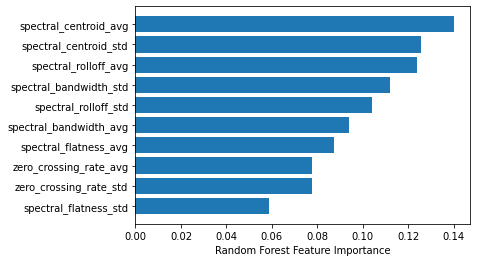

In [48]:
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Notes

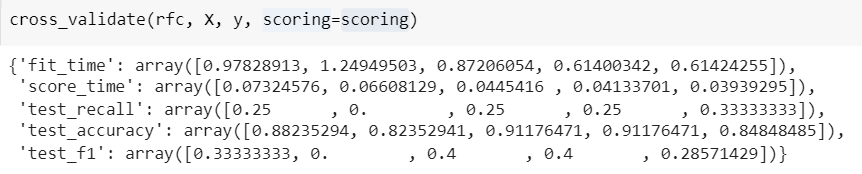

In [ ]:
#Notes
integers = np.array([i for i in range(1, 50)])
min_samples_split_steps = list(np.linspace(0.0, 1, 50)).append(integers)

#min_samples_leaf_steps = np.append(np.linspace(0.0, 0.5, 50), integers)